- CBOWモデル（continuous bag-of-words）
    -入力層
        - 入力層が複数個ある
        - コンテキストとしてN個の単語を扱う場合、入力層はN個になる
    - 中間層
        - 各入力層の全結合による変換後の値が「平均」されたもの
    - 出力層
        - 出力層は１層辺りの入力層のニューロン数ある
            - これらのニューロンは入力データの各単語に対応している
            - 出力層のニューロンは各単語の「スコア」
                - この値が高ければ高いほど、それに対応した単語の出現確率も高くなる
                - このスコアにSoftmax関数を適用させると確率に変換される

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sys

import sys, os
sys.path.append('../../../../deep-learning-from-scratch-2/') 
from common.util import preprocess, convert_one_hot


In [14]:
text = 'You say goodbye and I say hello.'

# コーパスの作成
corpus, word_to_id, id_to_word = preprocess(text)

In [17]:
# コンテキストとターゲットを作成
def create_contexts_target(corpus, window_size):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [16]:
contexts, target = create_contexts_target(corpus, 1)

In [18]:
contexts, target

(array([[0, 2],
        [1, 3],
        [2, 4],
        [3, 1],
        [4, 5],
        [1, 6]]),
 array([1, 2, 3, 4, 1, 5]))

In [20]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [21]:
contexts, target

(array([[[1, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1]]], dtype=int32),
 array([[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]], dtype=int32))

In [29]:
# MatMulは行列の積算
from common.layers import MatMul, SoftmaxWithLoss
from common.trainer import Trainer
from common.optimizer import Adam

In [32]:
SoftmaxWithLoss()

In [37]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # レイヤの作成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 全ての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = 0.5 * (h0 + h1)
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 798 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 799 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 800 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 801 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 802 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 803 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 804 |  iter 1 / 2 | time 0[s] | loss 0.78
| epoch 805 |  iter 1 / 2 | time 0[s] | loss 0.41
| epoch 806 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 807 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 808 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 809 |  iter 1 / 2 | time 0[s] | loss 0.38
| epoch 810 |  iter 1 / 2 | time 0[s] | loss 0.78
| epoch 811 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 812 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 813 |  iter 1 / 2 | time 0[s] | loss 0.45
| epoch 814 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 815 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 816 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 817 |  iter 1 / 2 | time 0[s] | loss 0.82


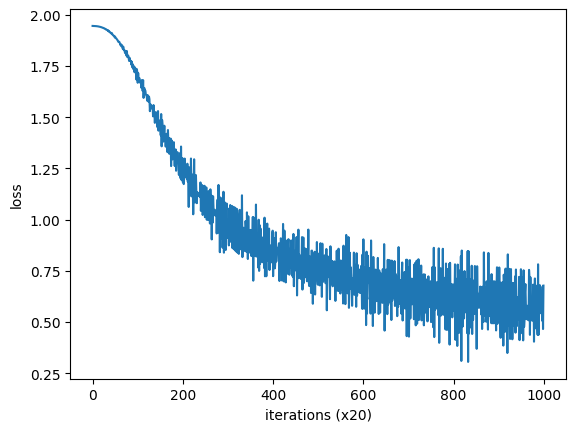

In [38]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()